In [ ]:
# Nima Shafie    Comp 541    Data Mining    Group Project
# Linear Regression on National Park Service
# From 2018 - 2021 to determine booking horizon
import numpy as np
import pandas as pd
import os, sys, time
from google.colab import files, drive
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.core.dtypes.cast import astype_array
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

# use to mount the google drive in order to obtain the dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# open data using pandas from google drive
nps_df = pd.read_csv(
    r"/content/drive/My Drive/School/Comp 541/20-joshua-tree.csv")
#    r"/content/drive/My Drive/put-your-path-here/18-21-joshua-tree.csv")

# from each park, use the most popular campsite 18-21 (291884 tuples x 8 features)
#  r"/content/drive/MyDrive/School/Comp 541/18-21_FinalDataset.csv")
# after one-hot -> 35 features

# takes about 23 minutes to run
# using all parks in 2021
#  r"/content/drive/MyDrive/School/Comp 541/18-21_FinalDataset.csv")
# with one-hot-encoding 238577 rows × 82 columns

# prints out a snapshot of the data frame before transforming
display(nps_df)

,parentlocation,park,sitetype,startdate,enddate,orderdate,numberofpeople,equipmentdescription
0,Joshua Tree National Park,JUMBO ROCKS CAMPGROUND,STANDARD NONELECTRIC,1/1/2020,1/1/2020,7/5/2019,6,RV
1,Joshua Tree National Park,JUMBO ROCKS CAMPGROUND,STANDARD NONELECTRIC,1/1/2020,1/1/2020,7/5/2019,6,Tent
2,Joshua Tree National Park,JUMBO ROCKS CAMPGROUND,STANDARD NONELECTRIC,1/1/2020,1/1/2020,7/6/2019,6,Tent
3,Joshua Tree National Park,JUMBO ROCKS CAMPGROUND,STANDARD NONELECTRIC,1/1/2020,1/1/2020,7/6/2019,6,Tent
4,Joshua Tree National Park,BLACK ROCK CAMPGROUND,STANDARD NONELECTRIC,1/1/2020,1/1/2020,7/6/2019,2,Trailer
...,...,...,...,...,...,...,...,...
52377,Joshua Tree National Park,JUMBO ROCKS CAMPGROUND,STANDARD NONELECTRIC,12/31/2020,1/2/2021,12/4/2020,2,Caravan/Camper Van
52378,Joshua Tree National Park,INDIAN COVE CAMPGROUND,STANDARD NONELECTRIC,12/31/2020,1/1/2021,12/4/2020,2,Tent
52379,Joshua Tree National Park,JUMBO ROCKS CAMPGROUND,TENT ONLY NONELECTRIC,12/31/2020,1/1/2021,12/6/2020,2,Tent
52380,Joshua Tree National Park,BLACK ROCK CAMPGROUND,TENT ONLY NONELECTRIC,12/31/2020,1/2/2021,12/6/2020,3,Tent


In [ ]:
# this cell must only be run once to avoid an error
# dropping parent location (if we're performing this model per park)
nps_df = nps_df.drop(["parentlocation"], axis=1)

# one hot encoder
def one_hot_encoder(feature_to_encode):
    dummy = pd.get_dummies(nps_df[[feature_to_encode]])
    df = pd.concat([nps_df, dummy], axis=1)
    df = df.drop([feature_to_encode], axis=1)
    return(df)

nps_df = one_hot_encoder("park")
nps_df = one_hot_encoder("sitetype")
nps_df = one_hot_encoder("equipmentdescription")

In [ ]:
display(nps_df)

for col_name in nps_df.columns:
  print(col_name)

,startdate,enddate,orderdate,numberofpeople,park_BLACK ROCK CAMPGROUND,park_BLACK ROCK EQUESTRIAN CAMPGROUND,park_COTTONWOOD CAMPGROUND (CA),park_COTTONWOOD GROUP,park_INDIAN COVE CAMPGROUND,park_Indian Cove Group,...,equipmentdescription_Fifth Wheel,equipmentdescription_Large Tent Over 9X12`,equipmentdescription_Pickup Camper,equipmentdescription_Pop up,equipmentdescription_RV,equipmentdescription_RV/Motorhome,equipmentdescription_Small Tent,equipmentdescription_Tent,equipmentdescription_Trailer,equipmentdescription_Vehicle
0,1/1/2020,1/1/2020,7/5/2019,6,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1/1/2020,1/1/2020,7/5/2019,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1/1/2020,1/1/2020,7/6/2019,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1/1/2020,1/1/2020,7/6/2019,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1/1/2020,1/1/2020,7/6/2019,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52377,12/31/2020,1/2/2021,12/4/2020,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52378,12/31/2020,1/1/2021,12/4/2020,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
52379,12/31/2020,1/1/2021,12/6/2020,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52380,12/31/2020,1/2/2021,12/6/2020,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


startdate
enddate
orderdate
numberofpeople
park_BLACK ROCK CAMPGROUND
park_BLACK ROCK EQUESTRIAN CAMPGROUND
park_COTTONWOOD CAMPGROUND (CA)
park_COTTONWOOD GROUP
park_INDIAN COVE CAMPGROUND
park_Indian Cove Group
park_JUMBO ROCKS CAMPGROUND
park_Ryan Campground
park_SHEEP PASS GROUP
sitetype_EQUESTRIAN NONELECTRIC
sitetype_GROUP STANDARD NONELECTRIC
sitetype_GROUP TENT ONLY AREA NONELECTRIC
sitetype_MANAGEMENT
sitetype_STANDARD NONELECTRIC
sitetype_TENT ONLY ELECTRIC
sitetype_TENT ONLY NONELECTRIC
equipmentdescription_Car
equipmentdescription_Caravan/Camper Van
equipmentdescription_Fifth Wheel
equipmentdescription_Large Tent Over 9X12`
equipmentdescription_Pickup Camper
equipmentdescription_Pop up
equipmentdescription_RV
equipmentdescription_RV/Motorhome
equipmentdescription_Small Tent
equipmentdescription_Tent
equipmentdescription_Trailer
equipmentdescription_Vehicle


In [ ]:
# feature engineering
# create a new column called friday_or_saturday
# which will be 1 if startdate is friday or saturday
# monday = 0, sunday = 6
# converting the date object to date data type
nps_df[["startdate", "enddate", "orderdate"]] = nps_df[["startdate", "enddate", "orderdate"]].apply(pd.to_datetime)

# creates the friday_or_saturday feature as explained above
nps_df.insert(loc=3,
              column="friday_or_saturday",
              value=nps_df['startdate'].dt.dayofweek)

# marks whether a camping 
def weekend_feature():
  for i in range(len(nps_df["startdate"])):
    if nps_df.loc[i, "friday_or_saturday"] == 4 or nps_df.loc[i, "friday_or_saturday"] == 5:
      nps_df.loc[i, "friday_or_saturday"] = 1
    else:
      nps_df.loc[i, "friday_or_saturday"] = 0

# create a nights stayed feature that stores the number of nights a group stays
nps_df.insert(loc=4,
              column="nights_stayed",
              value=nps_df['startdate'].dt.dayofweek)

# determine number of nights and input it into a feature
def nights_stayed_feature():
  for i in range(len(nps_df["startdate"])):
    d1 = nps_df.loc[i, "startdate"]
    d2 = nps_df.loc[i, "enddate"]
    nights = abs((d2-d1).days) + 1
    nps_df.loc[i, "nights_stayed"] = nights

weekend_feature()
nights_stayed_feature()

In [ ]:
# creating the target/label here
# booking_horizon is the number of days between a campsite booking date
# and the date the campers arrive on site
def calculate_horizon(i):
  d1 = nps_df.loc[i, "startdate"]
  d2 = nps_df.loc[i, "orderdate"]
  answer = abs((d2 - d1).days)
  return answer

# create the column here
nps_df.insert(loc=3,
              column="booking_horizon",
              value=0)

for i in range(len(nps_df["booking_horizon"])):
  nps_df.loc[i, "booking_horizon"] = calculate_horizon(i)

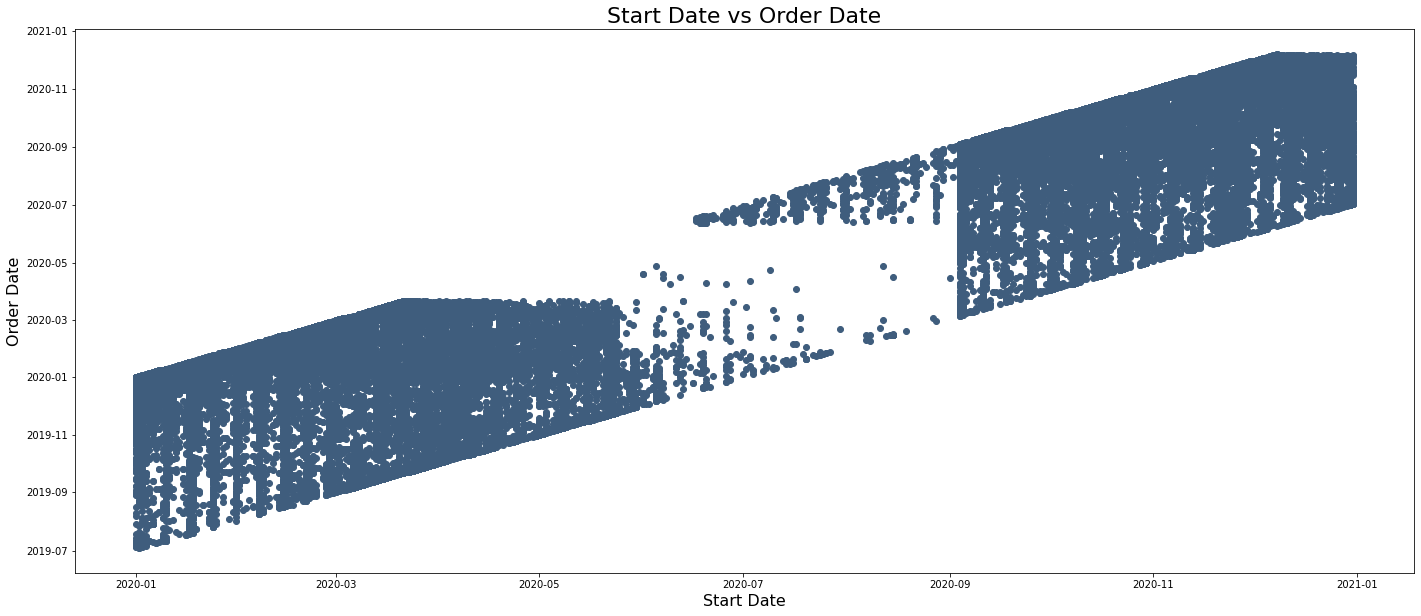

In [ ]:
# visualization
plt.figure(figsize=(24,10))
plt.scatter(nps_df[['startdate']].values,
           nps_df[['orderdate']].values,color="#3F5D7D")
plt.ylabel('Order Date',fontsize=16)
plt.xlabel('Start Date',fontsize=16)
plt.title('Start Date vs Order Date',
          fontsize=22)
plt.show()

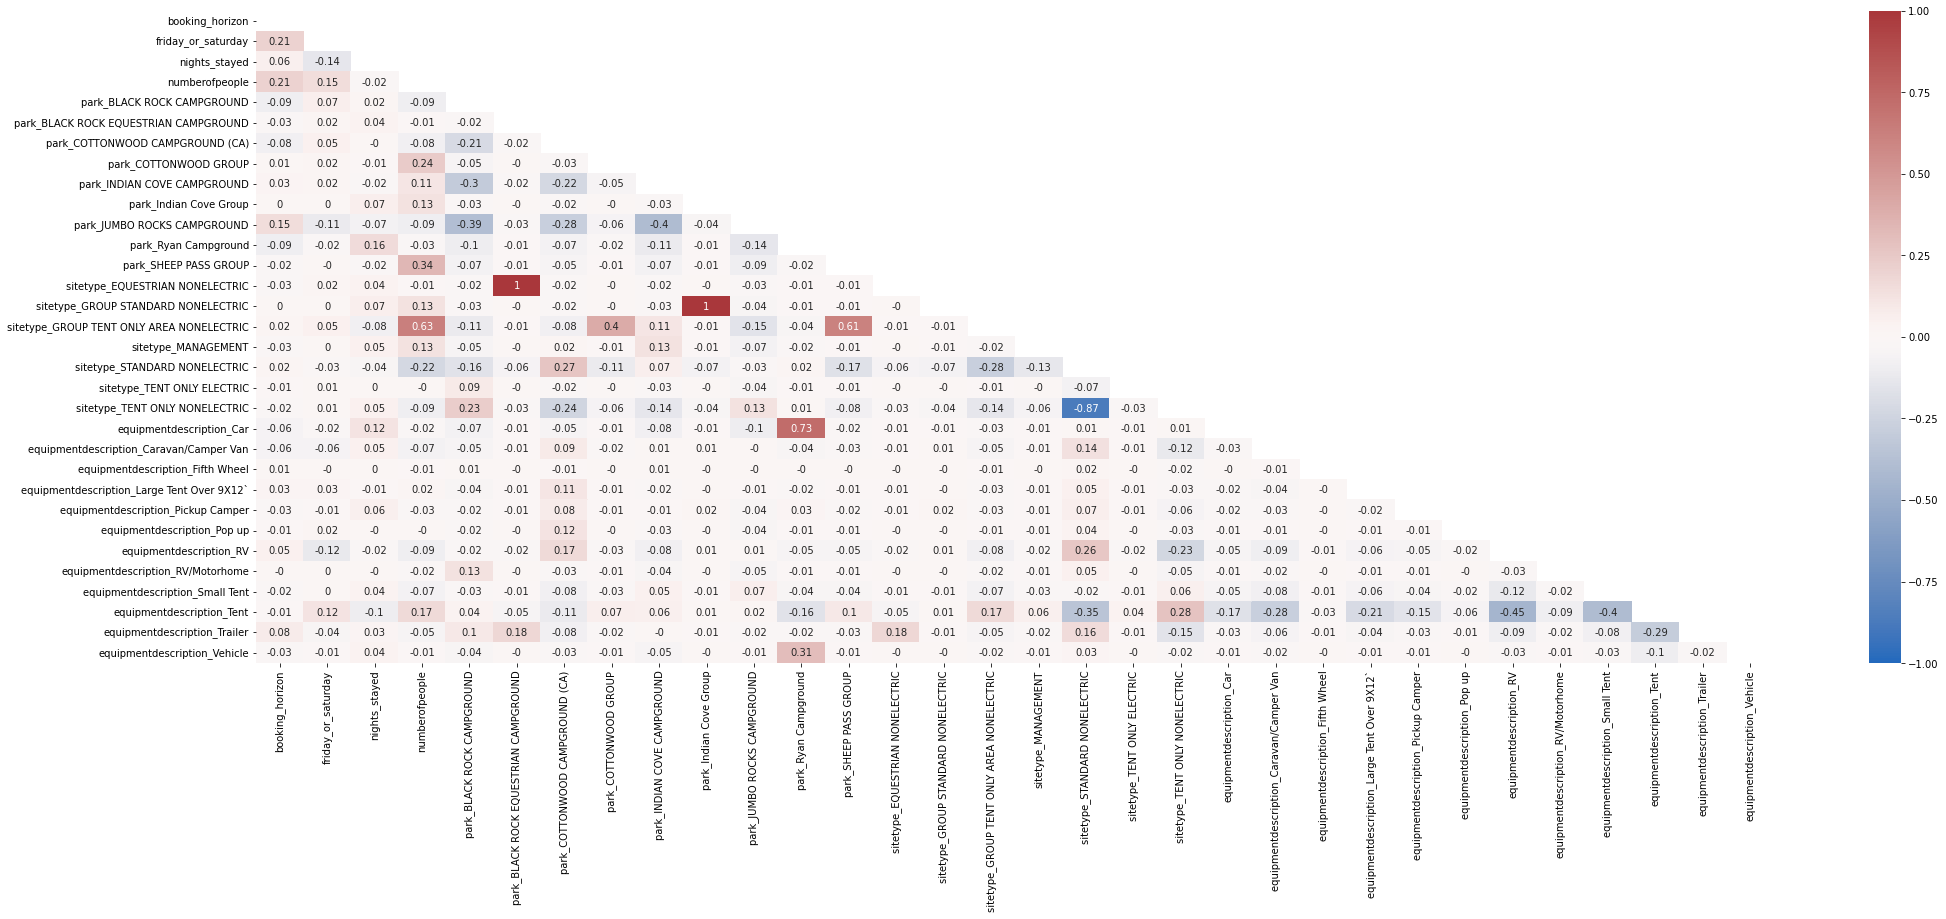

In [ ]:
# visualize correlation from corr matrix
plt.figure(figsize=(34,12))
matrix = nps_df.corr().round(2)
sns.heatmap(matrix, annot=True, vmin=-1, vmax=1, cmap='vlag',
           mask = np.triu(np.ones_like(matrix, dtype=bool)))
plt.show()

In [ ]:
# convert dates to ints for regression
# NOTE**: this bock of code MUST only be run once, or else you need to restart
# the entire colab sheet to prevent errors

# convert all date objects to ints in order for regression to run
def date_to_int(date):
  nps_df[date] = (nps_df[date] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1d")
  
date_to_int("startdate")
date_to_int("enddate")
date_to_int("orderdate")

In [ ]:
display(nps_df)
nps_df.dtypes

,startdate,enddate,orderdate,booking_horizon,friday_or_saturday,nights_stayed,numberofpeople,park_BLACK ROCK CAMPGROUND,park_BLACK ROCK EQUESTRIAN CAMPGROUND,park_COTTONWOOD CAMPGROUND (CA),...,equipmentdescription_Fifth Wheel,equipmentdescription_Large Tent Over 9X12`,equipmentdescription_Pickup Camper,equipmentdescription_Pop up,equipmentdescription_RV,equipmentdescription_RV/Motorhome,equipmentdescription_Small Tent,equipmentdescription_Tent,equipmentdescription_Trailer,equipmentdescription_Vehicle
0,18262,18262,18082,180,0,1,6,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,18262,18262,18082,180,0,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,18262,18262,18083,179,0,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,18262,18262,18083,179,0,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18262,18262,18083,179,0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52377,18627,18629,18600,27,0,3,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52378,18627,18628,18600,27,0,2,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52379,18627,18628,18602,25,0,2,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52380,18627,18629,18602,25,0,3,3,1,0,0,...,0,0,0,0,0,0,0,1,0,0


startdate                                     int64
enddate                                       int64
orderdate                                     int64
booking_horizon                               int64
friday_or_saturday                            int64
nights_stayed                                 int64
numberofpeople                                int64
park_BLACK ROCK CAMPGROUND                    uint8
park_BLACK ROCK EQUESTRIAN CAMPGROUND         uint8
park_COTTONWOOD CAMPGROUND (CA)               uint8
park_COTTONWOOD GROUP                         uint8
park_INDIAN COVE CAMPGROUND                   uint8
park_Indian Cove Group                        uint8
park_JUMBO ROCKS CAMPGROUND                   uint8
park_Ryan Campground                          uint8
park_SHEEP PASS GROUP                         uint8
sitetype_EQUESTRIAN NONELECTRIC               uint8
sitetype_GROUP STANDARD NONELECTRIC           uint8
sitetype_GROUP TENT ONLY AREA NONELECTRIC     uint8
sitetype_MAN

In [ ]:
# split the data in training/testing
# 80% training / 20% testing

# create X and y based on input/output
X = nps_df
X = X.drop(columns=["booking_horizon", "orderdate"])
y = nps_df["booking_horizon"]

# creating training/testing variables and setting the testing data size to 20%
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
display(nps_df)

,startdate,enddate,orderdate,booking_horizon,friday_or_saturday,nights_stayed,numberofpeople,park_BLACK ROCK CAMPGROUND,park_BLACK ROCK EQUESTRIAN CAMPGROUND,park_COTTONWOOD CAMPGROUND (CA),...,equipmentdescription_Fifth Wheel,equipmentdescription_Large Tent Over 9X12`,equipmentdescription_Pickup Camper,equipmentdescription_Pop up,equipmentdescription_RV,equipmentdescription_RV/Motorhome,equipmentdescription_Small Tent,equipmentdescription_Tent,equipmentdescription_Trailer,equipmentdescription_Vehicle
0,18262,18262,18082,180,0,1,6,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,18262,18262,18082,180,0,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,18262,18262,18083,179,0,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,18262,18262,18083,179,0,1,6,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18262,18262,18083,179,0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52377,18627,18629,18600,27,0,3,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52378,18627,18628,18600,27,0,2,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52379,18627,18628,18602,25,0,2,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52380,18627,18629,18602,25,0,3,3,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# uncomment to run the different algorithms
# fiting for linear/ridgeCV/SGD regression
reg = LinearRegression()

# reg = make_pipeline(StandardScaler(),
#                     RidgeCV(alphas=[0.5, 1, 5, 10]))

# reg = make_pipeline(StandardScaler(),
#                     SGDRegressor(loss="squared_error", learning_rate=,
#                                  eta0=0.001, max_iter=5000, random_state = 123))

# from sklearn.svm import LinearSVR
# reg = make_pipeline(StandardScaler(),
#                      LinearSVR(random_state=123, tol=1e-4, max_iter=4000,
#                                loss="squared_epsilon_insensitive", dual=False))

reg.fit(train_X, train_y)

LinearRegression()

In [ ]:
# use k-fold CV to evaluate model
cv = KFold(n_splits=10)

# define cross-validation method to use
scores = cross_val_score(reg, train_X, train_y,
                         cv=cv, n_jobs=-1)

#view accuaracy
print(scores.mean())

0.1889702617951808


In [ ]:
# displaying evaluation for our model
pred_y = reg.predict(test_X)
print("R2 Score: %0.4f" %r2_score(test_y, pred_y))

from sklearn.metrics import mean_absolute_error
print("MAE Score: %0.2f" %mean_absolute_error(test_y, pred_y))

from sklearn.metrics import mean_squared_error
print("MSE Score: %0.2f "%mean_squared_error(test_y, pred_y))

R2 Score: 0.1935
MAE Score: 42.44
MSE Score: 2674.81 


In [ ]:
# list of scores below for each algorithm

# ElasticNet Regression (Linear regression with combined L1 and L2 priors as regularizer)
# R2 Score: 0.1346
# MAE Score: 44.99
# MSE Score: 2870.21

# Lasso Regression (Linear Model trained with L1 prior as regularizer (aka the Lasso)
# R2 Score: 0.1625
# MAE Score: 43.70
# MSE Score: 2777.67

# SGD Regression (Linear model fitted by minimizing a regularized empirical loss with SGD)
# R2 Score: 0.1686
# MAE Score: 43.25
# MSE Score: 2757.40

# Ridge Regression (Linear least squares with l2 regularization)
# R2 Score: 0.1863
# MAE Score: 42.73
# MSE Score: 2698.92

# RidgeCV (Ridge regression with built-in cross-validation)
# R2 Score: 0.1935
# MAE Score: 42.44
# MSE Score: 2674.78 

# Linear Regression (Ordinary least squares Linear Regression)
# R2 Score: 0.1935
# MAE Score: 42.44
# MSE Score: 2674.80

########

# joshua tree without any feature engineering or outlier cleaning 2020
# R2 Score: 0.1314
# MAE Score: 52.28
# MSE Score: 3142.44

# joshua tree without equip 2020
# R2 Score: 0.1769
# MAE Score: 43.00
# MSE Score: 2729.84

# joshua tree with equip 2020
# R2 Score: 0.1935
# MAE Score: 42.44
# MSE Score: 2674.79 

########################################

# 21 only channel island without any feature engineering or outlier cleaning
# R2 Score: 0.18139323336118862
# MAE Score: 46.27995272939183
# MSE Score: 3386.442603157866 

# 21 only channel island without days features
# R2 Score: 0.22744940731632557
# MAE Score: 42.6599971483967
# MSE Score: 2618.424200716855 

# 21 only channel island with days features
# R2 Score: 0.2418485375177707
# MAE Score: 42.072285096405786
# MSE Score: 2569.620884344053 

# 21 only channel island with friday_saturday features
# R2 Score: 0.29687662689600025
# MAE Score: 39.92812501015206
# MSE Score: 2383.1128649188922

#########################

# from each park, use the most popular campsite 18-21
# R2 Score: 0.1925
# MAE Score: 46.57
# MSE Score: 2975.68 

In [ ]:
# converts back to date (this isn't fully working yet)
# from datetime import timedelta
# def int_to_date(date):
#   X[date] = pd.to_datetime(X[date], unit="d")
  
# int_to_date("startdate")
# int_to_date("enddate")

# min_value = nps_df['startdate'].min()
# y = pd.to_datetime(y, unit="d")
#display(X)
# for i in range(len(nps_df["startdate"])):
#   y.loc[i] = y.loc[i] + timedelta(days=17520)

# display(y)

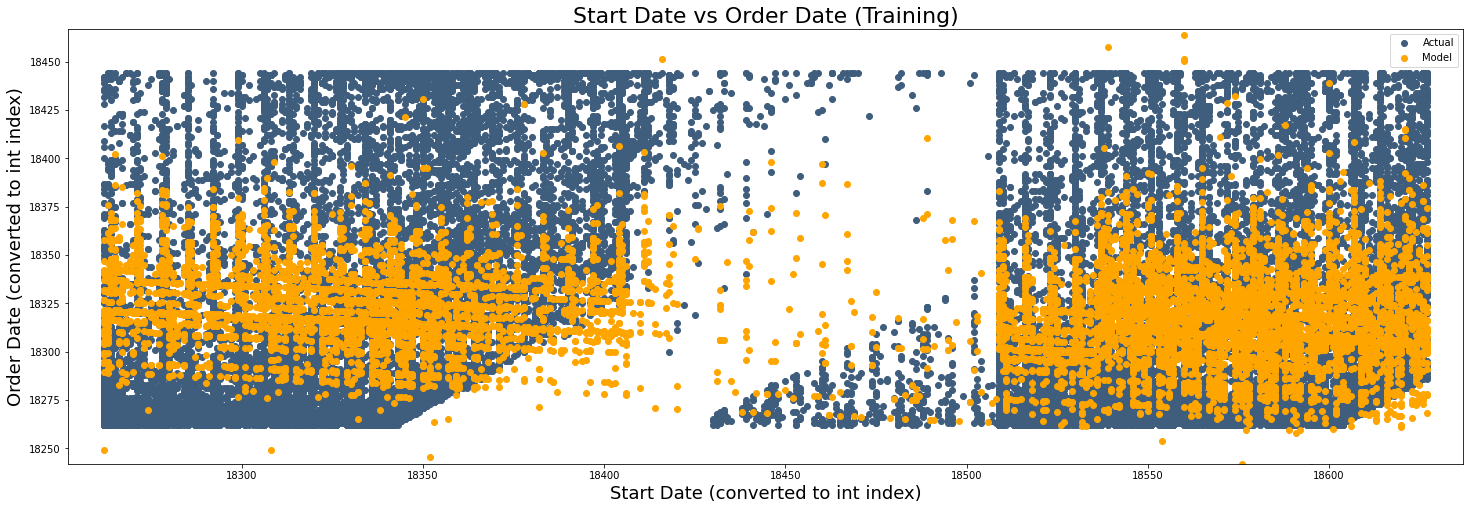

In [ ]:
# visualization of training graph scatterplot
min_value = X['startdate'].min()
max_value = X['startdate'].max()

plt.figure(figsize=(25,8))
plt.xlabel('Start Date (converted to int index)', fontsize=18)
plt.ylabel('Order Date (converted to int index)', fontsize=18)
plt.title('Start Date vs Order Date (Training)',
          fontsize=22)
plt.scatter(train_X[['startdate']].values,
            train_y.values + min_value, color="#3F5D7D", label="Actual")
plt.scatter(test_X.iloc[:,0], (pred_y + min_value), color='orange', label="Model")
plt.ylim(min_value-20, max_value-160)
plt.xlim(min_value-10, max_value+10)
plt.legend(loc="best")
plt.show()

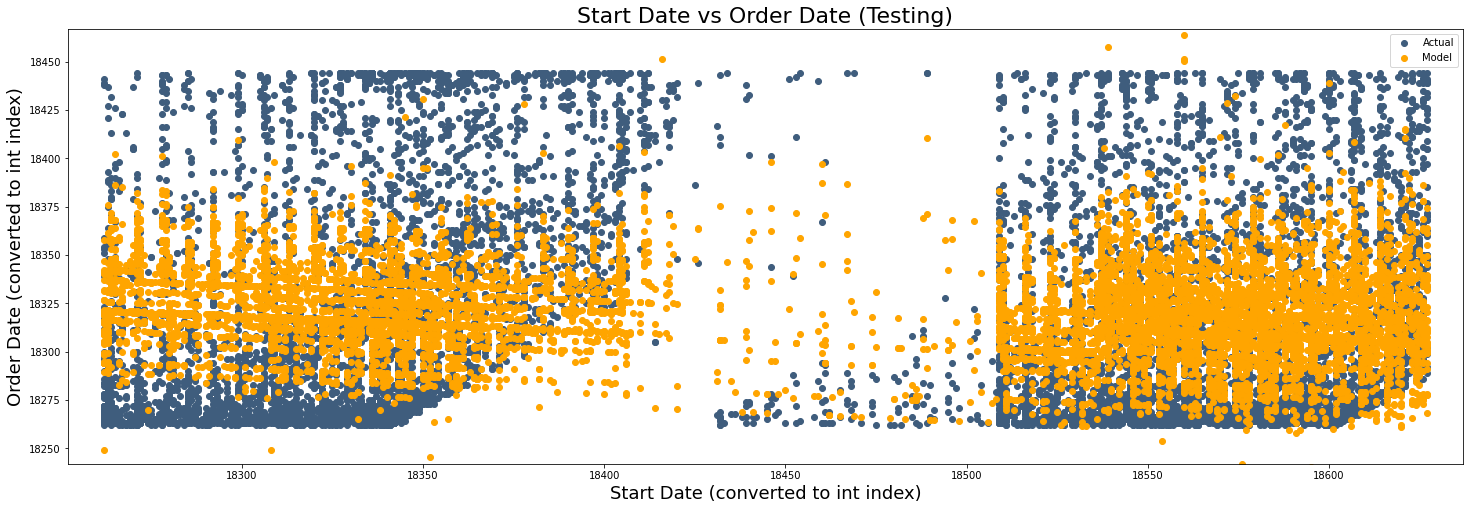

In [ ]:
# visualization of testing graph scatterplot
min_value = X['startdate'].min()
max_value = X['startdate'].max()

plt.figure(figsize=(25,8))
plt.xlabel('Start Date (converted to int index)', fontsize=18)
plt.ylabel('Order Date (converted to int index)', fontsize=18)
plt.title('Start Date vs Order Date (Testing)',
          fontsize=22)
plt.scatter(test_X[['startdate']].values,
            test_y.values + min_value, color="#3F5D7D", label="Actual")
plt.scatter(test_X.iloc[:,0], (pred_y + min_value), color='orange', label="Model")
plt.ylim(min_value-20, max_value-160)
plt.xlim(min_value-10, max_value+10)
plt.legend(loc="best")
plt.show()

In [ ]:
cv_results = cross_validate(reg, X, y,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [ ]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.1f} ± {train_error.std():.1f}")

Mean squared error of linear regression model on the train set:
2676.1 ± 90.7


In [ ]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.1f} ± {test_error.std():.1f}")

Mean squared error of linear regression model on the test set:
2969.0 ± 945.9


In [ ]:
print(f"RMSE of linear regression model:\n"
      f"{mean_squared_error(test_y, pred_y, squared=False):.1f}")

RMSE of linear regression model:
51.7


Mean training scores

 760      1842.526076
2470     8154.166171
4180    57839.956431
5890     4409.860546
7600     3603.560951
dtype: float64



Mean validation scores

 760     64690.631584
2470    19178.946725
4180    56515.329064
5890     4946.163671
7600     3565.120562
dtype: float64


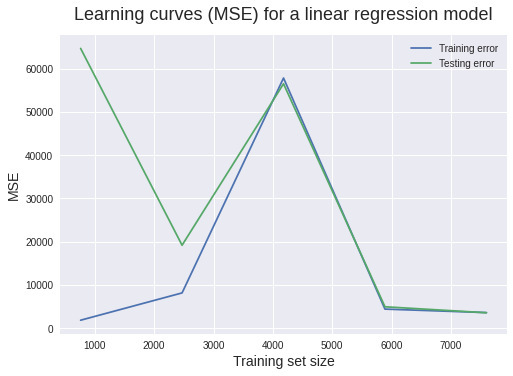

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
estimator = reg,
X = X[2500:12000],
y = y[2500:12000], cv = 5,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(1)
test_scores_mean = -test_scores.mean(1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, test_scores_mean, label = 'Testing error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves (MSE) for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n')
print('\nMean validation scores\n\n',pd.Series(test_scores_mean, index = train_sizes))

Mean training scores

 1600     21.218431
5200      1.218738
8800      7.043358
12400     0.609388
16000     0.891179
dtype: float64



Mean validation scores

 1600     59.594553
5200      2.289833
8800      6.264345
12400     0.381564
16000     0.830629
dtype: float64


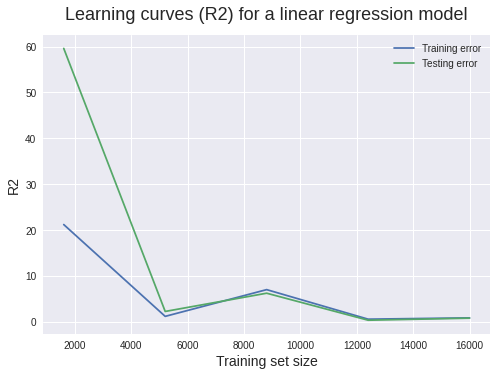

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
estimator = reg,
X = X[:20000],
y = y[:20000], cv = 5,
scoring = 'r2')

train_scores_mean = -train_scores.mean(1)
test_scores_mean = -test_scores.mean(1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, test_scores_mean, label = 'Testing error')
plt.ylabel('R2', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves (R2) for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n')
print('\nMean validation scores\n\n',pd.Series(test_scores_mean, index = train_sizes))